In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import dedalus.public as de

from dedalus.core.field import Operand
from dedalus.core.operators import Operator, FutureField, Interpolate


In [2]:
nr = 10
ntheta = 128
nz =128

Lz = 4.

In [3]:
r = de.Chebyshev('r', nr, interval=[7,8])
theta = de.Fourier('theta',ntheta)
z = de.Fourier('z',nz, interval=[0,Lz])

domain = de.Domain([z,theta,r], grid_dtype='float')

In [4]:
field = domain.new_field()

In [5]:
coeff = domain.all_elements()

In [6]:
for i in range(domain.dim):
    print(coeff[i].shape)

(64, 1, 1)
(1, 127, 1)
(1, 1, 10)


In [33]:
class GQLProjection(Operator, FutureField):
    """
    Projection operator for generalized quasilinear approximation
    
    
    """
    def __init__(self, arg, cutoff, subspace, dim=None,**kw):
        arg = Operand.cast(arg)
        super().__init__(arg,**kw)
        self.cutoff = cutoff
        
        # by default, execute GQL on all but the last dimension
        if not dim:
            self.dim = self.domain.dim - 1
        else:
            self.dim = dim
        
        local_coeff = domain.all_elements()
        low_mask = np.ones(domain.local_coeff_shape, dtype='bool')

        for i in range(self.dim):
            low_mask &= (np.abs(coeff[i]) <= cutoff[i])
        if subspace == 'high' or subspace == 'h':
            self.mask = ~low_mask
        elif subspace == 'low' or 'subspace' == 'l':
            self.mask = low_mask
        else:
            raise ValueError("Subspace must be high/h or low/l, not {}".format(subspace))

    def meta_constant(self, axis):
        # Preserve constancy
        return self.args[0].meta[axis]['constant']

    def check_conditions(self):
        """Projection must be in coefficient space""" 
        return self.args[0].layout is self._coeff_layout
    
    def operate(self, out):
        for i in range(self.dim):
            self.args[0].require_layout('c')
        out.data[:] = self.args[0].data
        out.data *= self.mask
        

In [34]:
zz,tt,rr = domain.grids()

In [72]:
#field['g'] = (np.sin(16*np.pi/Lz*zz) + np.sin(4*np.pi/Lz*zz))*(np.sin(8*tt) + np.sin(2*tt))
field['g'] = ( np.sin(4*np.pi/Lz*zz))*(np.sin(2*tt)) + ( np.sin(16*np.pi/Lz*zz))*(np.sin(8*tt)) 

<IPython.core.display.Javascript object>


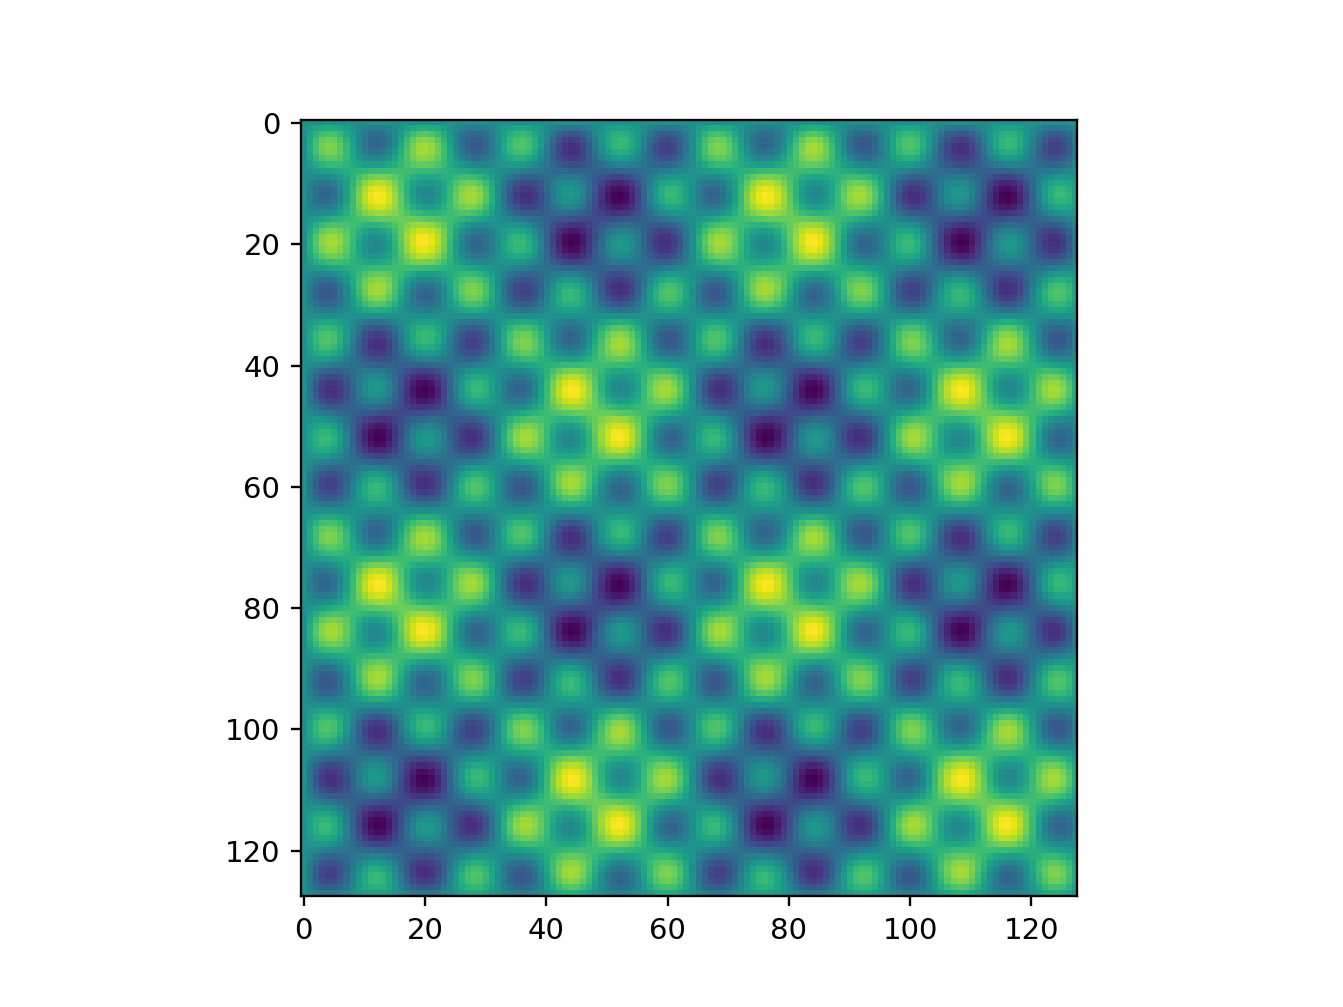

In [73]:
plt.figure()
plt.imshow(field['g'][:,:,1])

In [74]:
low = GQLProjection(field,[8,8],'low').evaluate()
hi = GQLProjection(field,[8,8],'high').evaluate()

<IPython.core.display.Javascript object>


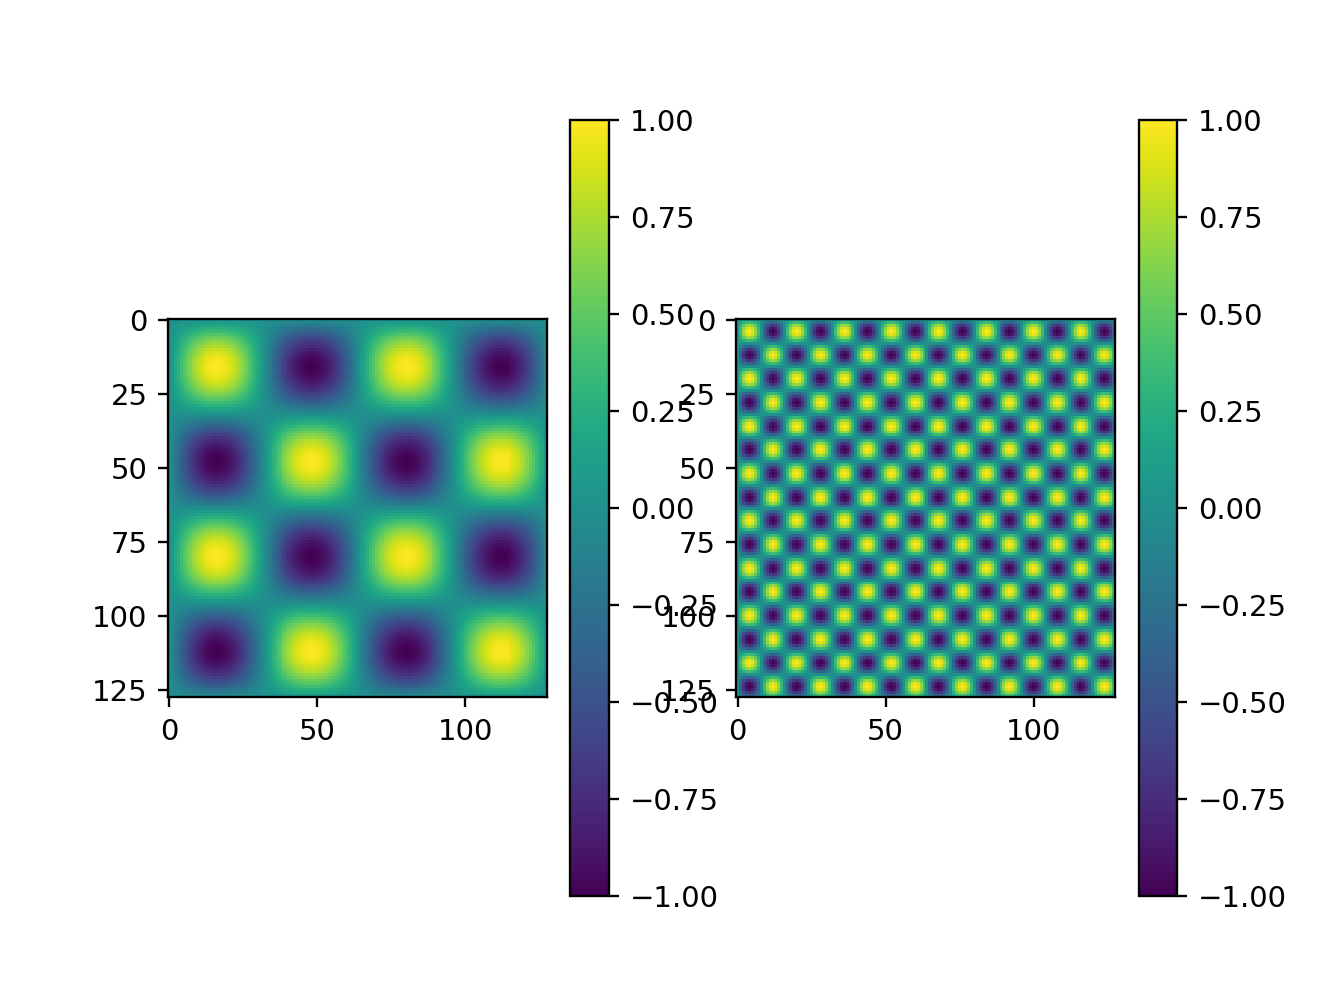

In [75]:
plt.figure()
plt.subplot(121)
plt.imshow(low['g'][:,:,1])
plt.colorbar()
plt.subplot(122)
plt.imshow(hi['g'][:,:,1])
plt.colorbar()

In [69]:
lp =  GQLProjection(field,[8,8],'low')
hp =  GQLProjection(field,[8,8],'high')

<IPython.core.display.Javascript object>


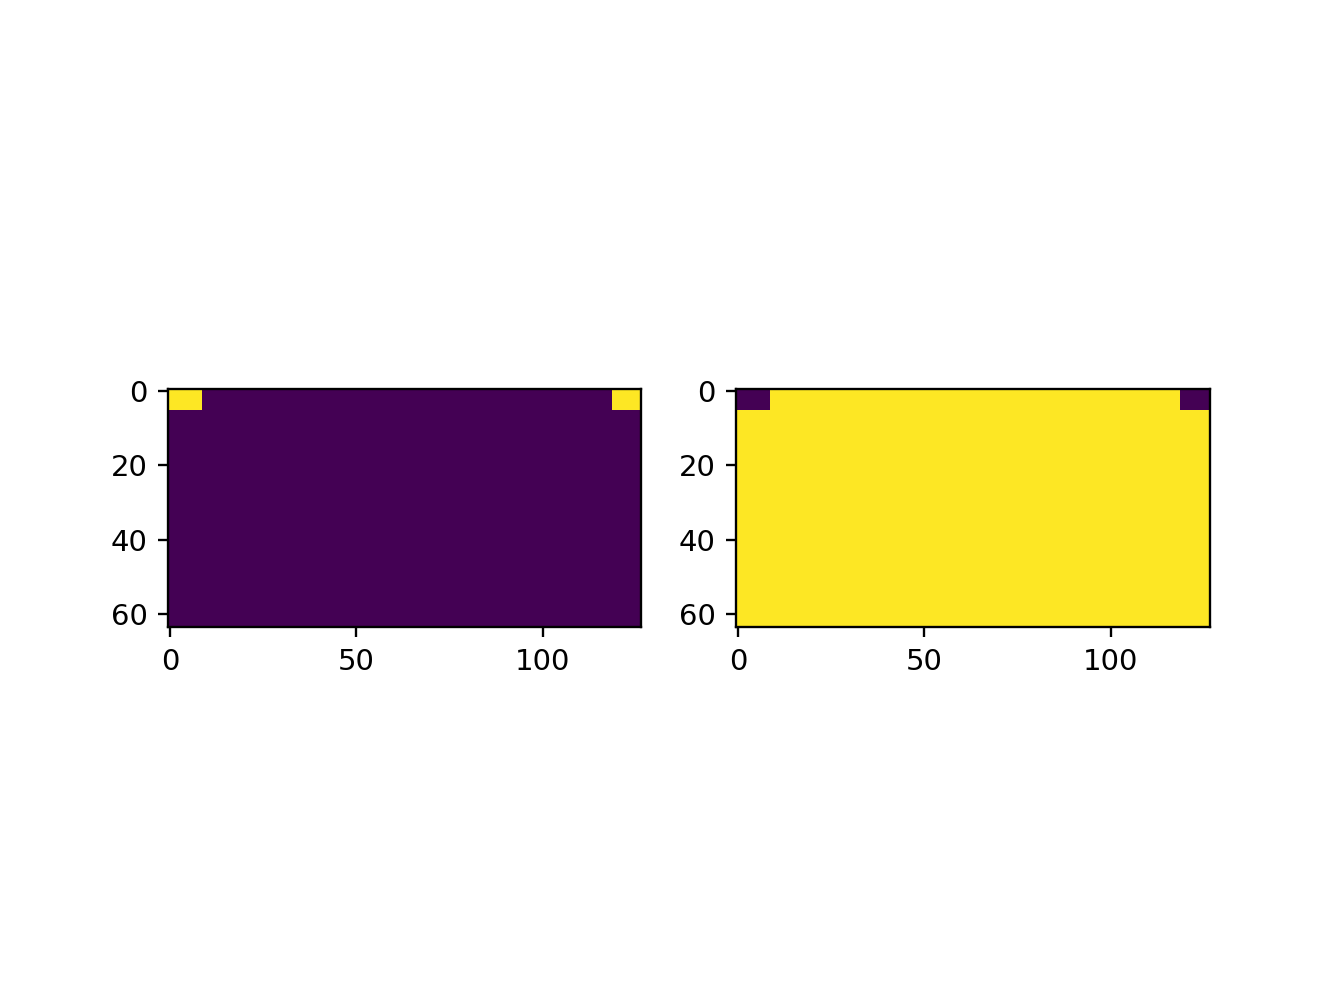

In [70]:
plt.figure()
plt.subplot(121)
plt.imshow(lp.mask[:,:,0])
plt.subplot(122)
plt.imshow(hp.mask[:,:,0])

In [71]:
lp.mask.shape

(64, 127, 10)